# <center> Neural Networks and Deep Learning (CSCI 5922)</center>
# <center> Spring 2020 </center>

**Name:** Nicholas Varberg

## Goal

The goal of this assignment is to introduce neural networks in terms of ideas you are already familiar with:  linear regression and classification

## Dataset

You are given a dataset with 2 input variables ($x_1$, $x_2$) and an output variable ($y$).

In [1]:
from sklearn.datasets import make_regression
from matplotlib import pyplot
import numpy as np
import os

# Load data
data = np.loadtxt(os.path.join('data', 'assign1_data.txt'),  delimiter=',')
X = data[:,:2]
y = data[:, 2]
z = data[:, 3]

## Part 1

Write a program to find the exact least squares solution to $y = w_1 x_1 + w_2 x_2 + b$ for the above dataset, using the normal equation.

Complete the following function below and use it to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given function.

In [2]:
def least_squares(X, y):
    """
    Finds the Least Squares solution
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of output value 'y' (size : no of examples X 1)
    
    Returns
    -------
    w : solution array
    """
    # Add array of ones to X so that intercept (b) is solved as well
    b_col = np.array([1]*len(X)).reshape((len(X),1))
    X_b    = np.append(X, b_col, axis=1)
    # Solve w with the normal equation
    w     = np.matmul(np.matrix(np.matmul(X_b.T,X_b)).I,np.matmul(X_b.T,y))
    return w

(A) Report the values of $w_1$, $w_2$, and $b$.

In [3]:
w = least_squares(X,y)
print('w1 is ', w[0,0])
print('w2 is ', w[0,1])
print('b is  ', w[0,2])

w1 is  -2.044242595137638
w2 is  3.996860168659319
b is   -0.9242908118675865


(B) What function or method did you use to find the least-squares solution?

I used the normal equation to get the exact solution for w:
<center> $w = (X^{T}X)^{-1}(X^{T}y)$

## Part 2

Implement linear regression of y on X via first-order optimization of the least-squares objective. Write a program that determines the coefficients {w1,w2,b}. Implement stochastic gradient descent, batch gradient descent, and mini-batch gradient descent. You will need to experiment with updating rules, step sizes (i.e. learning rates), stopping criteria, etc. Experiment to find settings that lead to solutions with the fewest number of sweeps through the data.

Complete the following functions below and use them to answer questions (A), (B) and (C). You may find the shuffle function from scikit-learn useful. 

Use the following hyperparameters:

Learning rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]

MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]

**Note:** Please do not change the interface of the given functions.

In [4]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score

def online_epoch(X, y, w, alpha):
    """
    One epoch of stochastic gradient descent (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    
    for i in shuffle(range(len(X))):
        xi = X[i]
        yi = y[i]
        grad = (yi - w.T*xi)*xi
        w  = w + alpha*grad
    return w

def batch_update(X, y, w, alpha):
    """
    One iteration of full-batch gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    # use average gradient to update
    ave_grad = np.mean( (y - np.dot(X,w)).reshape(-1, 1)*X, axis=0 )
    w        = w + alpha*ave_grad
    return w

def mini_batch_update(X, y, w, alpha, batch_size):
    """
    One epoch of mini-batch SGD over the entire dataset (i.e. one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    batch_size : size of the batch for gradient update
    
    Returns
    -------
    Coefficients of the model (after updating)
    """
    shuffled_i = shuffle(np.arange(len(X)))
    start      = 0
    while start < len(shuffled_i):
        end            = min(start + batch_size, len(shuffled_i))
        X_mini, y_mini = X[shuffled_i[start:end]], y[shuffled_i[start:end]]
        w              = batch_update(X_mini, y_mini, w, alpha)
        start          = start + batch_size
    return w

def least_squares_grad_desc(X, y, maxIter, alpha, update, *batch_size):
    """
    Implements least squares with gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : Maximum number of iterations allowed
    alpha : Learning rate
    update : update function to utilize (one of online, batch, mini-batch)
    batch_size : number of examples in a batch (only useful when update = mini_batch_update)
    
    Returns
    -------
    Coefficients of the model (after updating)
    
    Note : *batch_size is an optional argument and only to be used when doing 
    mini-batch Gradient Descent 
    """
    # Add array of ones to X so that intercept (b) is solved as well
    b_col   = np.array([1]*len(X)).reshape(-1,1)
    X_b     = np.append(X, b_col, axis=1)
    w       = np.zeros(len(X_b[0]))
    w_old   = np.ones(len(X_b[0]))
    # Stop when change is small or when reached maxIter 
    epsilon = 0.000001
    i       = 0
    # List to store mean squared error
    mse = []
    while (max( abs((w - w_old)/w_old) ) > epsilon) & (i < maxIter):
        w_old = w
        if update == mini_batch_update:
            w = update(X_b, y, w, alpha, batch_size[0])
        else:
            w = update(X_b, y, w, alpha)
        mse.append( mean_squared_error(y, np.dot(X_b,w)) )
        i    += 1
    print( max( abs((w - w_old)/w) ), ' change' )
    print(i,'/',maxIter, ' iter')
    return w, X_b, mse

(A) Report the values of $w_1$, $w_2$, and $b$. 

In [5]:
w, X_b, mse = least_squares_grad_desc(X, y, 1000, 0.99, batch_update, 10)
print('w1 is ', w[0])
print('w2 is ', w[1])
print('b is  ', w[2])

9.419615453446646e-07  change
183 / 1000  iter
w1 is  -2.044245068429012
w2 is  3.9968358768683876
b is   -0.9242772856067061


/Users/nickvarberg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide


(B) What settings worked well for you:  online vs. batch vs. minibatch? What step size? How did you decide to terminate?

(C) Make a graph of error on the entire data set as a function of epoch. An epoch is a complete sweep through all the data (which is one iteration for full-batch gradient descent).

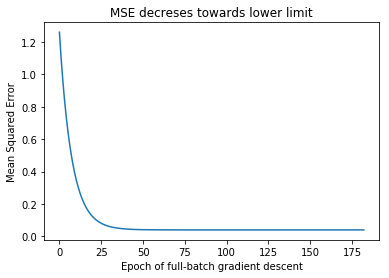

In [6]:
x_plot = np.arange(0, len(mse))
pyplot.plot(x_plot,mse)
pyplot.xlabel('Epoch of full-batch gradient descent')
pyplot.ylabel('Mean Squared Error')
pyplot.title('MSE decreses towards lower limit')
pyplot.show()

## Part 3

The data set from a regression problem can be converted into a classification problem simply by using the sign of (+ or -) as representing one of two classes. In the data set used in Part 1 and 2, you'll see the variable z that represents this binary (0 or 1) class.

Use the perceptron learning rule to solve for the coefficients {$w_1$, $w_2$, $b$} of this classification problem.   

Two warnings: First, your solution to Part 3 should require only a few lines of code changed from the code you wrote for Part 2. Second, the Perceptron algorithm will not converge if there is no exact solution to the training data. It will jitter among coefficients that all yield roughly equally good solutions.

Complete the following functions below and use them to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given functions.

In [36]:
def perceptron_update(X, y, w, alpha):
    """
    One epoch of Perceptron updates (full sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    incorrect : Incorrectly classified examples
    """
    shuffled_i = shuffle(range(len(X)))
    for i in shuffled_i:
        xi = X[i]
        yi = y[i]
        if yi*np.dot(xi,w) <= 0:
            w  = w + alpha*xi
    return w

def perceptron(X, y, maxIter, alpha):
    """
    Implements the Perceptron algorithm.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : The maximum number of iterations allowed 
    alpha : Learning Rate
    
    Returns
    -------
    w : Coefficients of the classifier
    incorrect : Incorrectly classified examples on termination
    """
    # Add array of ones to X so that intercept (b) is solved as well
    b_col   = np.array([1]*len(X)).reshape(-1,1)
    X_b     = np.append(X, b_col, axis=1)
    w       = np.zeros(len(X_b[0]))
    w_old   = np.ones(len(X_b[0]))
    # Stop when change is small or when reached maxIter 
    epsilon = 0.000001
    i       = 0
    # List to store accuracy
    acc = []
    while (max( abs((w - w_old)/w_old) ) > epsilon) & (i < maxIter):
        w      = perceptron_update(X_b, y, w, alpha)
        y_pred = []
        for pred in np.dot(X_b,w):
            if pred < 0:
                y_pred.append(0)
            else:
                y_pred.append(1)
        acc.append( accuracy_score(y,np.array(y_pred)) )
        i      += 1
    return w, acc

(A) Report the values of coefficients $w_1$, $w_2$, and $b$.

In [42]:
z_neg = []
for zi in z:
    if zi == 0:
        z_neg.append(-1)
    else:
        z_neg.append(1)
z_neg = np.array(z_neg)
z_neg
w, acc = perceptron(X, y=z_neg, maxIter=1000, alpha=0.05)
print('w1 is ', w[0])
print('w2 is ', w[1])
print('b is  ', w[2])

w1 is  1203.314999999993
w2 is  560.684999999989
b is   2249.9999999994197


(B) Make a graph of the accuracy (% correct classification) on the training set as a function of epoch.

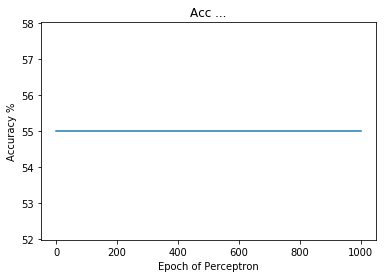

In [41]:
x_plot = np.arange(0, len(acc))
pyplot.plot(x_plot,np.array(acc)*100)
pyplot.xlabel('Epoch of Perceptron')
pyplot.ylabel('Accuracy %')
pyplot.title('Acc ...')
pyplot.show()

## Part 4

In machine learning, we really want to train a model based on some data and then expect the model to do well on "out of sample" data. Try this with the code you wrote for Part 3:  Train the model on the first {5, 10, 25, 50, 75} examples in the data set and test the model on the final 25 examples.

Complete the following function below and use it to answer (A). 

**Note:** Please do not change the interface of the given function.

In [ ]:
def classify(X, y, w):
    """
    Use this function to classify examples in the test set
    
    Parameters
    ----------
    X : Test set features
    y : Test set labels
    w : Perceptron coefficients
    
    Returns
    -------
    correct : number of correctly classified examples
    """
    pass

How does performance on the test set vary with the amount of training data? Make a bar graph showing performance for each of the different training set sizes.